Calculating Mutual Information...

Top 10 Features by Mutual Information:
                                  Feature  Mutual Information
29               scaled__scaler__duration            0.076841
35              scaled__scaler__euribor3m            0.074559
33         scaled__scaler__cons_price_idx            0.066235
34          scaled__scaler__cons_conf_idx            0.065298
36            scaled__scaler__nr_employed            0.064294
32           scaled__scaler__emp_var_rate            0.055847
37       pass__passthrough__pdays_missing            0.034885
31               scaled__scaler__previous            0.024222
21    categorical__binary_encode__month_2            0.015366
18  categorical__binary_encode__contact_1            0.015089


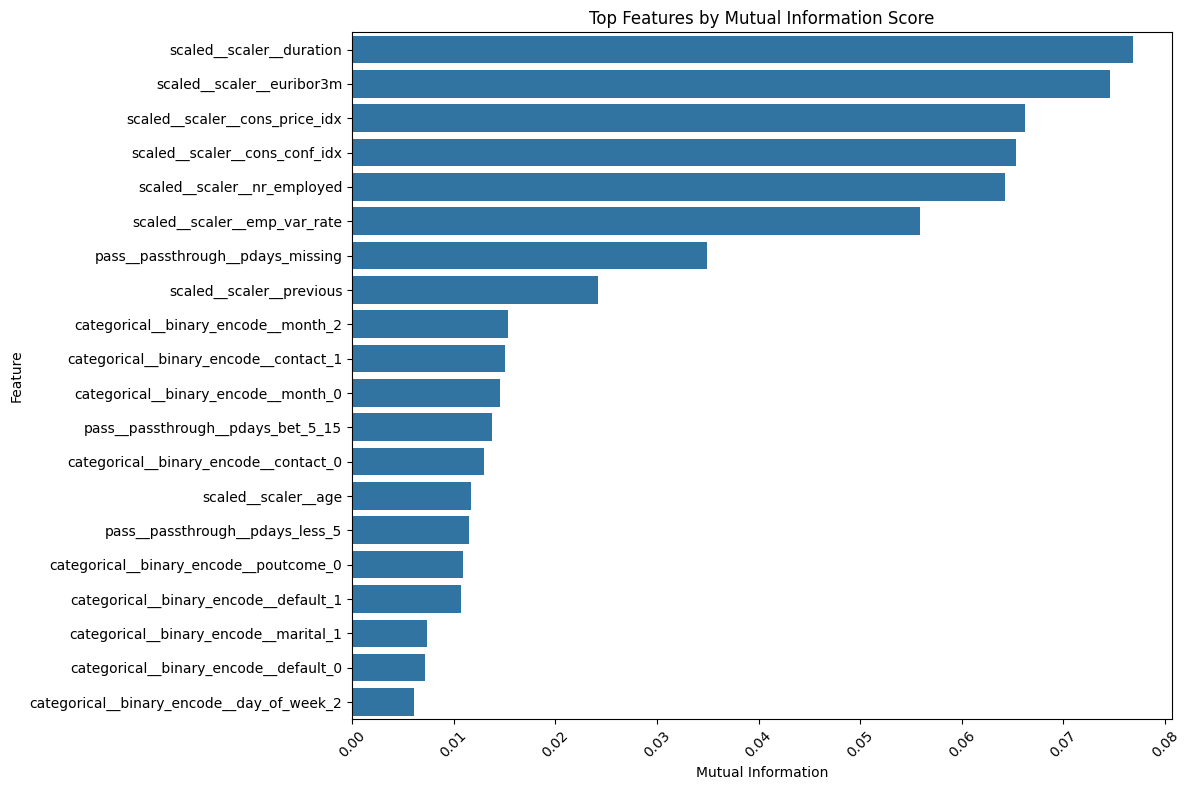


Analyzing Multicollinearity...

Highly Correlated Feature Pairs (|correlation| >= 0.8):
                                 Feature1  \
5  categorical__binary_encode__poutcome_0   
8            scaled__scaler__emp_var_rate   
7            scaled__scaler__emp_var_rate   
9               scaled__scaler__euribor3m   
6  categorical__binary_encode__poutcome_1   
4  categorical__binary_encode__poutcome_0   
2      categorical__binary_encode__loan_0   
1   categorical__binary_encode__housing_0   
0   categorical__binary_encode__default_0   
3   categorical__binary_encode__contact_0   

                                 Feature2  Correlation  
5                scaled__scaler__previous     0.998348  
8             scaled__scaler__nr_employed     0.944050  
7               scaled__scaler__euribor3m     0.939782  
9             scaled__scaler__nr_employed     0.929309  
6                scaled__scaler__previous    -0.848249  
4  categorical__binary_encode__poutcome_1    -0.857149  
2      categoric

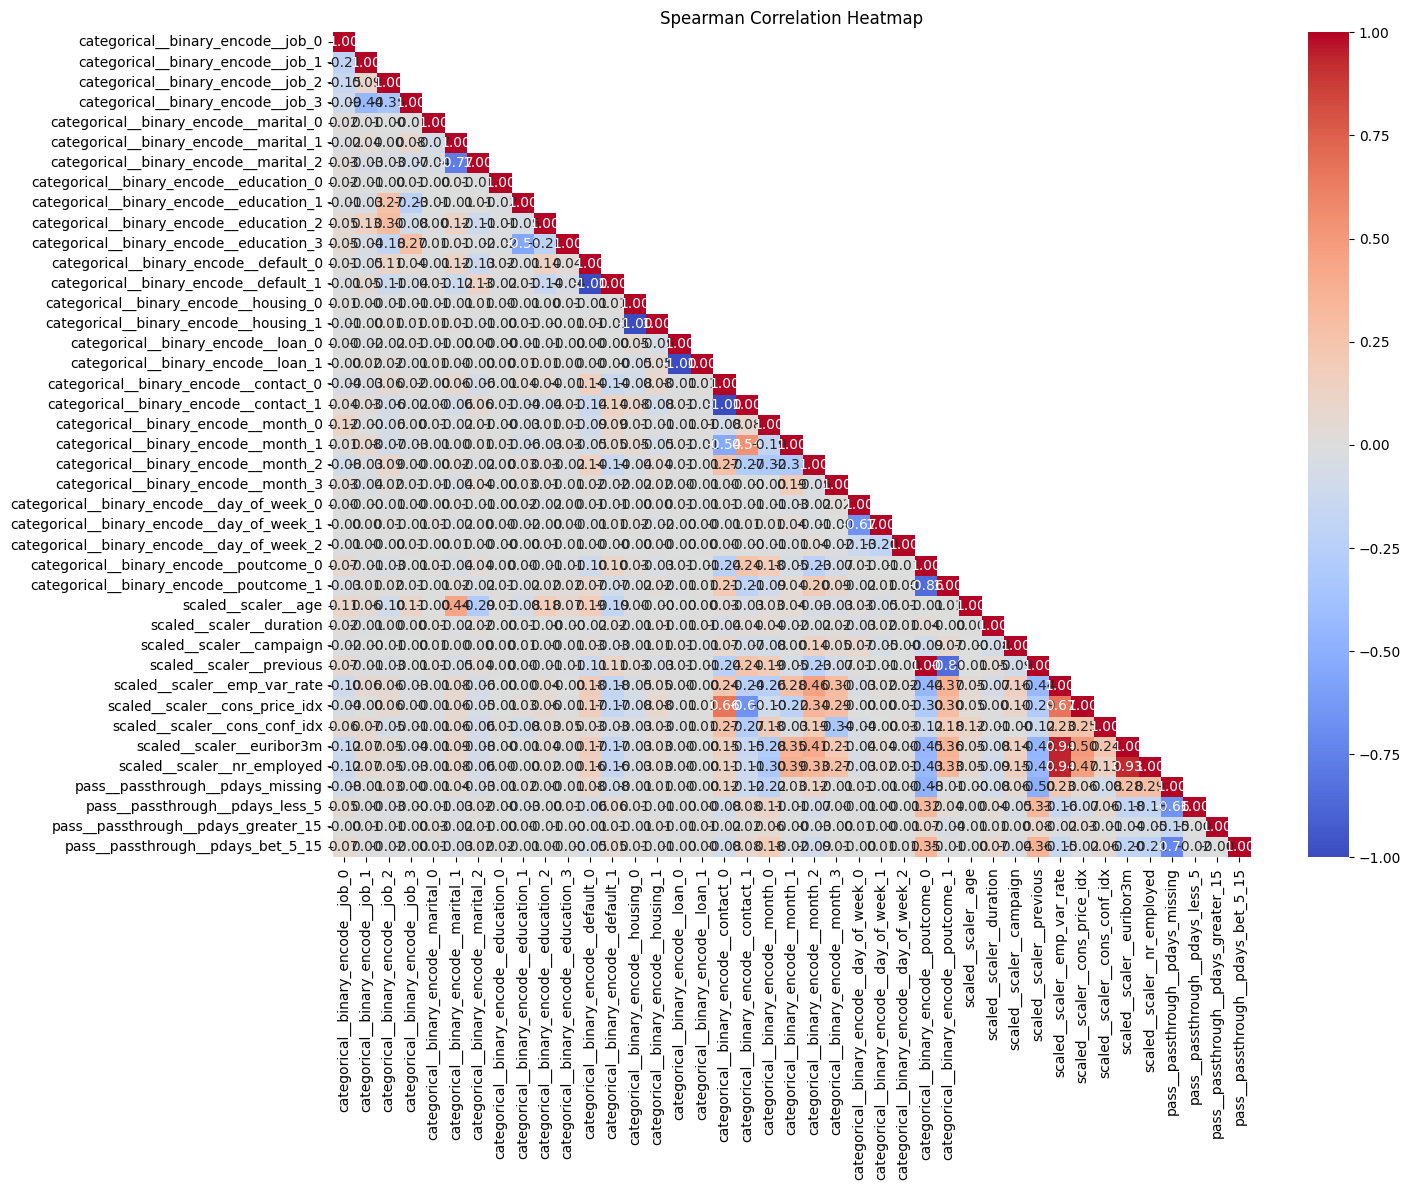


Recommended features to remove based on correlation analysis:
['categorical__binary_encode__contact_0', 'scaled__scaler__nr_employed', 'categorical__binary_encode__loan_1', 'categorical__binary_encode__poutcome_0', 'categorical__binary_encode__housing_1', 'categorical__binary_encode__poutcome_1', 'categorical__binary_encode__default_0', 'scaled__scaler__emp_var_rate']

Reduced feature set shape: (24712, 33)


In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import mutual_info_classif
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import os



# Define paths
BASE_PATH = os.path.abspath('..') 
PROCESSED_DATA_PATH = os.path.join(BASE_PATH, 'data', 'processed')
MODEL_PATH = os.path.join(BASE_PATH, 'models')

# Define file names
X_TRAIN = 'X_train.csv'
X_TEST = 'X_test.csv'
X_VALID = 'X_valid.csv'
Y_TRAIN = 'y_train.csv'
Y_TEST = 'y_test.csv'
Y_VALID = 'y_valid.csv'

# Set random seed for reproducibility
RANDOM_SEED = 123
np.random.seed(RANDOM_SEED)

# Load the preprocessed data
X_train = pd.read_csv(os.path.join(PROCESSED_DATA_PATH, X_TRAIN))
X_test = pd.read_csv(os.path.join(PROCESSED_DATA_PATH, X_TEST))
X_valid = pd.read_csv(os.path.join(PROCESSED_DATA_PATH, X_VALID))

y_train = pd.read_csv(os.path.join(PROCESSED_DATA_PATH, Y_TRAIN))
y_test = pd.read_csv(os.path.join(PROCESSED_DATA_PATH, Y_TEST))
y_valid = pd.read_csv(os.path.join(PROCESSED_DATA_PATH, Y_VALID))

# Since we already have preprocessed data, we'll use that
def load_processed_data():
    X_train = pd.read_csv(os.path.join(PROCESSED_DATA_PATH, X_TRAIN))
    y_train = pd.read_csv(os.path.join(PROCESSED_DATA_PATH, Y_TRAIN))
    return X_train, y_train

def calculate_mutual_information(X, y):
    """
    Calculate mutual information between features and target
    """
    # Calculate mutual information
    mi_scores = mutual_info_classif(X, y.values.ravel())
    
    # Create a dataframe with the scores
    mi_df = pd.DataFrame({
        'Feature': X.columns,
        'Mutual Information': mi_scores
    }).sort_values('Mutual Information', ascending=False)
    
    return mi_df

def plot_mutual_information(mi_df, top_n=20):
    """
    Plot mutual information scores
    """
    plt.figure(figsize=(12, 8))
    sns.barplot(data=mi_df.head(top_n), x='Mutual Information', y='Feature')
    plt.title('Top Features by Mutual Information Score')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def analyze_multicollinearity(X, threshold=0.8):
    """
    Analyze multicollinearity using Spearman correlation
    """
    # Calculate Spearman correlation matrix
    corr_matrix = X.corr(method='spearman')
    
    # Find highly correlated feature pairs
    high_corr_pairs = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            if abs(corr_matrix.iloc[i,j]) >= threshold:
                high_corr_pairs.append({
                    'Feature1': corr_matrix.columns[i],
                    'Feature2': corr_matrix.columns[j],
                    'Correlation': corr_matrix.iloc[i,j]
                })
    
    return pd.DataFrame(high_corr_pairs).sort_values('Correlation', ascending=False)

def plot_correlation_heatmap(X):
    """
    Plot correlation heatmap
    """
    plt.figure(figsize=(15, 12))
    mask = np.triu(np.ones_like(X.corr(method='spearman')), k=1)
    sns.heatmap(X.corr(method='spearman'), 
                mask=mask,
                annot=True, 
                fmt='.2f', 
                cmap='coolwarm', 
                center=0)
    plt.title('Spearman Correlation Heatmap')
    plt.tight_layout()
    plt.show()

def mitigate_multicollinearity(X, high_corr_df, mi_df):
    """
    Provide recommendations for handling multicollinearity
    """
    features_to_remove = set()
    
    for _, row in high_corr_df.iterrows():
        # Get mutual information scores for both features
        mi_1 = mi_df[mi_df['Feature'] == row['Feature1']]['Mutual Information'].values[0]
        mi_2 = mi_df[mi_df['Feature'] == row['Feature2']]['Mutual Information'].values[0]
        
        # Keep the feature with higher mutual information
        if mi_1 < mi_2:
            features_to_remove.add(row['Feature1'])
        else:
            features_to_remove.add(row['Feature2'])
    
    return list(features_to_remove)

# Main execution
def main():
    # Load data
    X_train, y_train = load_processed_data()
    
    # Calculate and plot mutual information
    print("Calculating Mutual Information...")
    mi_df = calculate_mutual_information(X_train, y_train)
    print("\nTop 10 Features by Mutual Information:")
    print(mi_df.head(10))
    plot_mutual_information(mi_df)
    
    # Analyze multicollinearity
    print("\nAnalyzing Multicollinearity...")
    high_corr_df = analyze_multicollinearity(X_train, threshold=0.8)
    print("\nHighly Correlated Feature Pairs (|correlation| >= 0.8):")
    print(high_corr_df)
    
    # Plot correlation heatmap
    plot_correlation_heatmap(X_train)
    
    # Get recommendations for feature removal
    features_to_remove = mitigate_multicollinearity(X_train, high_corr_df, mi_df)
    print("\nRecommended features to remove based on correlation analysis:")
    print(features_to_remove)
    
    # Create dataset with reduced features
    X_train_reduced = X_train.drop(columns=features_to_remove)
    print(f"\nReduced feature set shape: {X_train_reduced.shape}")
    
    return X_train_reduced, features_to_remove

if __name__ == "__main__":
    X_train_reduced, removed_features = main()